# Determine P-value threshold at chosen a FDR threshold

In this notebook, we describe how to determine a P-value threshold for a given dataset so that the FDR is kept below a chosen threshold. We use an empirical method to estimate the FDR at given P-value thresholds. For a given P-value threshold ``p_thresh``, we proceed in four steps:

1. Determine the number of significant interactions ``sig_num_o`` at ``p_thresh``.
2. Randomize the simple and twisted read pair counts of all interactions. We randomize individual interactions with $n$ read pairs by randomly drawing a simple count from a binomial distribution with $p=0.5$ and then setting the twisted count to $t=n-s$.
3. Determine the number of randomized significant interactions ``sig_num_r`` at ``p_thresh``.
4. Use ``sig_num_r/sig_num_o`` to estimate the FDR at ``p_thresh``.

To find a P-value threshold for which the FDR is kept below a chosen threshold, we estimate the FDR for increasing P-value thresholds. Then we use the largest P-value threshold for which the FDR is still below the chosen threshold. Note that we randomize each interaction only once and then use the same list of P-values of randomized interactions for all P-value thresholds.

Usually the FDR grows monotonically with the P-value threshold. However, for datasets with poor signal-to-noise ratio, this may not be the case. Therefore we check this and issue a warning if applicable.

## Setting up the notebook

In [1]:
import sys
import os
from numpy import arange
import pandas
sys.path.append("..")
from diachr import DiachromaticInteractionSet
from diachr import RandomizeInteractionSet

In this notebook, we use the following classes:
- ``DiachromaticInteractionSet``
- ``RandomizeInteractionSet``

We use the ``DiachromaticInteractionSet`` to read, evaluate, categorize and write interactions to a file. The randomization analyzes are carried out in class ``RandomizeInteractionSet``, which operates on an already existing ``DiachromaticInteractionSet`` object that has been passed to its constructor.

## Test files

### Test file 1

The purpose of the first test file is to check whether the P-value thresholds are used correctly during the FDR analysis. The function ``write_diachromatic_interaction_fdr_test_file`` of class ``DiachromaticInteractionSet`` can be used to generate a test file that contains the same number of interactions for consecutive P-value intervals of the same size. The following parameters must be specified:

- maximum P-value
- P-value step size
- requested number of interactions per interval
- input interaction file
- output interaction file

Make sure that the interaction file has not previously been categorized with a P-value threshold that is smaller than the specified maximum P-value. Otherwise, interactions that do not have enough read pairs to be significant at the smaller threshold may have already been discarded.

The maximum P-value and the step size are used to create a list of ascendingly sorted P-values that define intervals of equal size.

In [2]:
p_value_max = 0.05
p_value_step = 0.0025
p_threshs = arange(p_value_step, p_value_max + p_value_step, p_value_step)
print(p_threshs)

[0.0025 0.005  0.0075 0.01   0.0125 0.015  0.0175 0.02   0.0225 0.025
 0.0275 0.03   0.0325 0.035  0.0375 0.04   0.0425 0.045  0.0475 0.05  ]


And for each of these intervals, the requested number of interactions is selected from the input file and written into a new interaction file that can be used for testing.

In order to create a test file for the FDR module, we first read an interactions file from real data into a ``DiachromaticInteractionSet``.

In [3]:
interaction_input_file = '../tests/data/test_03/MK_0.06_evaluated_and_categorized_interactions.tsv.gz'
interaction_set_test = DiachromaticInteractionSet()
interaction_set_test.parse_file(interaction_input_file, verbose=False)
#read_file_info_report = interaction_set_test.get_read_file_info_report()
#print(read_file_info_report)

Then we create the test file with the function provided for this purpose.

In [4]:
write_test_file_info_dict = interaction_set_test.write_diachromatic_interaction_fdr_test_file(
    target_file='../tests/data/test_03/diachromatic_interaction_file_fdr_1.tsv',
    p_value_max = 0.05,
    p_value_step = 0.00025,
    i_per_interval_requested = 10,   
    verbose=True)

[INFO] Generating test file for FDR procedure ...
	[INFO] Iterating interaction set and writing interactions to test file ...
[INFO] ... done.


The function creates the new interaction file for testing and returns a table containing the number of selected interactions for each P-value interval. For the parameters given above, this table has rows for 200 intervals. For each interval, the current and cumulative number of selected interactions is reported.

In [5]:
pandas.set_option('display.max_rows', None)
pandas.DataFrame(write_test_file_info_dict['RESULTS_TABLE'])

,PVAL_INTERVAL,I_SELECTED,I_SELECTED_CUM
0,]0.00000;0.00025],10,10
1,]0.00025;0.00050],10,20
2,]0.00050;0.00075],10,30
3,]0.00075;0.00100],10,40
4,]0.00100;0.00125],10,50
5,]0.00125;0.00150],10,60
6,]0.00150;0.00175],10,70
7,]0.00175;0.00200],10,80
8,]0.00200;0.00225],10,90
9,]0.00225;0.00250],10,100


In this case, the requested number of 10 interactions could be selected for each of the 200 P-value intervals so that the output file contains 2000 interactions.

### Test files 2

To investigate the influence of the total number of input interactions on the estimation of the FDR, we created smaller files from a real interaction file by writing the top lines to new files. We have prepared test files with 1000, 10000, 100000, 1000000, 2000000, 4000000 and 8000000 interactions. Because of the file sizes, we have only added the first three files to this repository.

In [6]:
ls ../tests/data/test_03/*top*

../tests/data/test_03/diachromatic_interaction_file_fdr_top_1000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_10000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_100000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_1000000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_2000000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_4000000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_8000000.tsv.gz


## Check that P-value thresholds are being used  correctly

During the FDR procedure, the number of sigificant interactions is determined at different P-value thresholds. In addition, P-values and logarithmized P-values are used. This can lead to errors when usinng ``<``, ``<=``, ``>`` or ``>=``. Furthermore, the transformations log(p) and exp(log(p)) can lead to inaccuracies. To check whether the thresholds are being used  correctly, we apply our FDR procedure to the test file, which contains the same number of interactions for different P-value intervals.

First, we read the test file into an ``DiachromaticInteractionSet``. When creating this file, we have defined 200 intervals and selected 10 interactions for each interval. Therefore, we expect a total of 2000 interactions.

In [107]:
interaction_set = DiachromaticInteractionSet()
interaction_set.parse_file('../tests/data/test_03/diachromatic_interaction_file_fdr_1.tsv', verbose=False)
read_file_info_report = interaction_set.get_read_file_info_report()
print(read_file_info_report)

[INFO] Report on reading files:
	[INFO] Read interaction data from 1 files:
		[INFO] 2000 interactions from: 
			[INFO] ../tests/data/test_03/diachromatic_interaction_file_fdr_1.tsv
			[INFO] Set size: 2000
	[INFO] The interaction set has 2000 interactions.
[INFO] End of report.



Then we create an object of class ``RandomizeInteractionSet`` and, at the same time, pass the interaction set to this object. Finally, we call the function for the FDR procedure. We use the same values for the maximum P-value (``pval_thresh_max``) and the step size (``pval_thresh_step_size``) that we used when creating the test file.

In [108]:
randomize_fdr = RandomizeInteractionSet(interaction_set=interaction_set)
fdr_info_dict = randomize_fdr.get_pval_tresh_at_chosen_fdr_tresh(
    chosen_fdr_thresh = 0.05,
    pval_thresh_max = 0.05,
    pval_thresh_step_size = 0.00025,
    verbose = True)

[INFO] Performing FDR procedure ...
	[INFO] Getting list of observed P-values ...
	[INFO] Getting list of randomized P-values ...
	[INFO] Going through list of P-value thresholds and estimate FDR ...
	[INFO] Looking for largest P-value threshold for which the FDR is below the chosen threshold ...
		[INFO] P-value threshold: 0.00025
		[INFO] -ln(P-value) threshold: 8.29405
		[INFO] Number of randomized significant interactions: 0
		[INFO] Number of observed significant interactions: 10
		[INFO] Estimated FDR: 0.00000
[INFO] ... done.


../diachr/randomize_interaction_set.py:116: UserWarning: FDR did not grow monotonically with P-value threshold!
Take a close look at the results for each of the P-value thresholds.
  warnings.warn("FDR did not grow monotonically with P-value threshold!" + '\n' + \


For this example, a warning is issued because the FDR did not grow monotonically with the P-value thresholds. In such cases, the determined P-value threshold and the associated estimated FDR are not valid, which is to be expected for this test dataset.

We created this test file to test that the various P-value thresholds are used correctly. The function for the FDR procedure returns a table containing the results for all P-value thresholds. This table has the following columns:

- ``P_VAL_TRESH``: P-value threshold
- ``NNL_P_VAL_TRESH``: Negative of the natural logarithm of the P-value threshold
- ``SIG_NUM_R``: Number of randomized significant interactions
- ``SIG_NUM_O``: Number of observed significant interaction
- ``FDR``: Estimated FDR

Run the cell below to display this table.

In [110]:
pandas.set_option('display.max_rows', None)
pandas.DataFrame(fdr_info_dict['RESULTS_TABLE'])

,PVAL_THRESH,NNL_PVAL_THRESH,MIN_RP_NUM,MIN_RP_NUM_PVAL,SIG_NUM_R,SIG_NUM_O,FDR
0,0.00025,8.294050,13,0.000244,0,10,0.000000
1,0.00050,7.600902,12,0.000488,2,20,0.100000
2,0.00075,7.195437,12,0.000488,2,30,0.066667
3,0.00100,6.907755,11,0.000977,3,40,0.075000
4,0.00125,6.684612,11,0.000977,4,50,0.080000
5,0.00150,6.502290,11,0.000977,4,60,0.066667
6,0.00175,6.348139,11,0.000977,4,70,0.057143
7,0.00200,6.214608,10,0.001953,4,80,0.050000
8,0.00225,6.096825,10,0.001953,4,90,0.044444
9,0.00250,5.991465,10,0.001953,5,100,0.050000


In the number of significant interactions in column ``SIG_NUM_O`` increases by 10 for each P-value threshold. This is what we expect for this test dataset and we are testing this in a unit test. 

In [1]:
import sys
import os
from numpy import arange
import pandas
sys.path.append("..")
from diachr import DiachromaticInteractionSet
from diachr import RandomizeInteractionSet

## Influence of the total number of interactions on the estimation of the FDR

We investigated the influence of the total number of input interactions on the estimation of the FDR by downsampling. from an interaction file with approximately ``9,000,000`` interactions, we created seven smaller interaction files by writing the first ``1,000``, ``10,000``, ``100,000``, ``1,000,000``, ``2,000,000``, ``4,000,000`` and ``8,000,000`` lines each to a new file. Then we applied our FDR procedure with the same parameters to all files.

In [2]:
chosen_fdr_thresh = 0.05
p_value_max = 0.025
p_value_step = 0.00025

### 1,000 interactions

In [3]:
# Prepare interaction set
interaction_file_top_1000 = '../tests/data/test_03/diachromatic_interaction_file_fdr_top_1000.tsv.gz'
interaction_set_top_1000 = DiachromaticInteractionSet()
interaction_set_top_1000.parse_file(interaction_file_top_1000, verbose=False)
randomize_fdr_top_1000 = RandomizeInteractionSet(interaction_set=interaction_set_top_1000)

# Perform FDR procedure
fdr_info_dict_top_1000 = randomize_fdr_top_1000.get_pval_tresh_at_chosen_fdr_tresh(
    chosen_fdr_thresh = chosen_fdr_thresh,
    pval_thresh_max = p_value_max,
    pval_thresh_step_size = p_value_step,
    verbose = False)

# Print summary of results
fdr_info_report = randomize_fdr_top_1000.get_fdr_info_report()
print(fdr_info_report)

[INFO] Report on FDR procedure:
	[INFO] Input parameters:
		[INFO] Chosen FDR threshold: 0.05000
		[INFO] Maximum P-value threshold: 0.02500
		[INFO] P-value threshold step size: 0.00025
		[INFO] Total number of interactions: 1,000
	[INFO] Results:
		[INFO] Determined P-value threshold: 0.00750
		[INFO] Determined -ln(P-value threshold): 4.89285
		[INFO] Minimum read pair number: 9
		[INFO] Smallest possible P-value with 9 read pairs: 0.00391
		[INFO] Number of interactions with 9 or more read pairs: 686
		[INFO] Number of significant interactions: 26
		[INFO] Number of randomized significant interactions: 1
		[INFO] Estimated FDR: 0.03846
[INFO] End of report.



The function ``get_fdr_info_report`` returns a formatted string that contains informations about the input parameters and the final results. In this case, with only ``1,000`` interactions, a P-value threshold of ``0.0075`` is determined. This is the largest P-value threshold for which an FDR was estimated that was still below ``0.05``.  We use this threshold to categorize interactions as either directed or undirected. When evaluating interactions, we specify the negative of the natural logarithm of the P-value. Therefore, logarithmized theshold value is also reported, which is ``4.89285`` in this case. At the threshold that has been determined, an interaction must have at least  ``9`` read pairs in order to have a significant P-value, which corresponds to a P-value of ``0.00391``. This means that even the most extreme interaction with 8 read pairs, i.e. with only simple read pairs (``8:0``) or only twisted read pairs (``0:8``), cannot be significant at the determined threshold because the corresponding P-value ($0.00781$) is already above the threshold. Of the ``1,000`` interactions, ``686`` have ``9`` or more read pairs and therefore can potentially significant. ``26`` significant interactions were observed for the original data. After the simple and twisted read paair counts of all interactions were randomized, the number of significant interactions was ``1``. This gives an estimated FDR of ``0.03846`` ($1/26$).

In this case, the total number of interactions is small and more than 30% of the interactions cannot be significant because they do not have enough read pairs. After all, the FDR is estimated from very small numbers of interactions. For such sitauations, we recommend taking a closer look at the results. The function ``get_fdr_info_plot`` creates a plot that contains not only the final results but also a graaphical representation of all intermediate results. A text field in the header contains all informations that is also contained in the formatted string described above. Below that follows the first plot, which only contains the P-value thresholds that were passed through. The red dashed lines are drawn at the determined P-value threshold. This is followed by two plots that refer to the minimum number of read pairs that are necessary for significance at the various P-value thresholds. These upper three plots do not contain results related to the data. They result soley from the binomial model and the chosen step size for the P-value thresholds and serve as a reference for the interpretation for the lower two plots. The one plot shows the number of significant interactions for the original (orange) and randomized (blue) data and the plot at the bottom shows the estimated FDR at the different P-value thresholds.

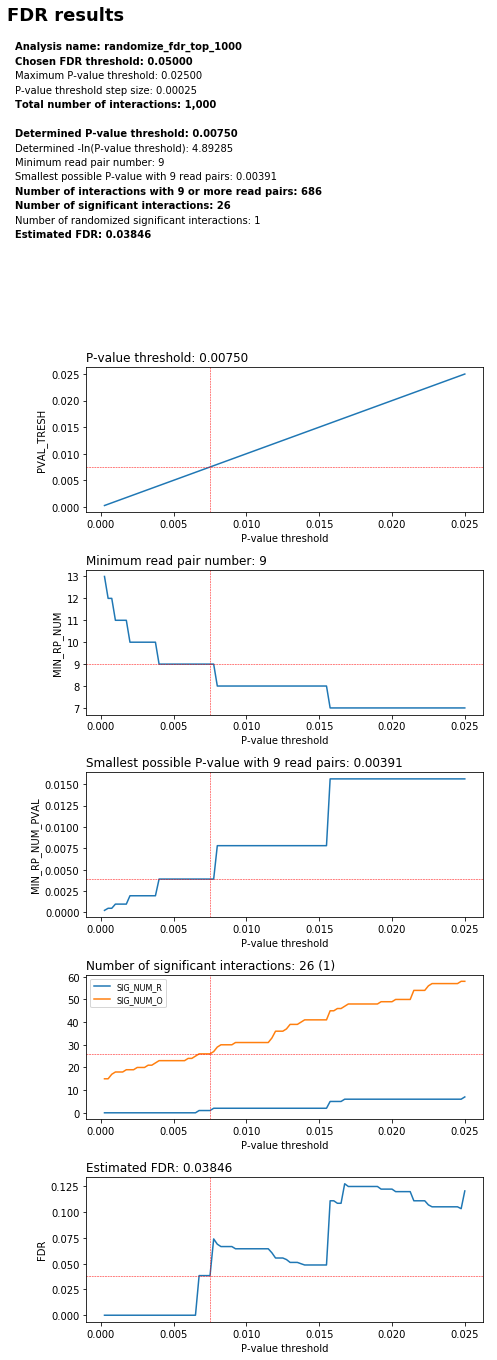

In [4]:
# Create a plot with the summary of the analysis
fig = randomize_fdr_top_1000.get_fdr_info_plot(
    pdf_file_name = 'randomize_fdr_top_1000.pdf',
    analysis_name = 'randomize_fdr_top_1000')

In this example, the FDR estimated for different P-value thresholds shows an unsual trend.

First of all, it is nocticable that the FDR increases sharply at two P-value thresholds.

In addition, it happens that the FDR decreases with increasing P-value thresholds.

Typically, one would expect the FDR to grow monotonically with the P-value threshold.

But in this example, it also happenns that the FDR decreases.

### 10,000 interactions

In [7]:
# Prepare interaction set
interaction_file_top_10000 = '../tests/data/test_03/diachromatic_interaction_file_fdr_top_10000.tsv.gz'
interaction_set_top_10000 = DiachromaticInteractionSet()
interaction_set_top_10000.parse_file(interaction_file_top_10000, verbose=False)
randomize_fdr_top_10000 = RandomizeInteractionSet(interaction_set=interaction_set_top_10000)

# Perform FDR procedure
fdr_info_dict_top_10000 = randomize_fdr_top_10000.get_pval_tresh_at_chosen_fdr_tresh(
    chosen_fdr_thresh = chosen_fdr_thresh,
    pval_thresh_max = p_value_max,
    pval_thresh_step_size = p_value_step)

# Print summary of results
fdr_info_report = randomize_fdr_top_10000.get_fdr_info_report()
print(fdr_info_report)

[INFO] Report on FDR procedure:
	[INFO] Input parameters:
		[INFO] Chosen FDR threshold: 0.05000
		[INFO] Maximum P-value threshold: 0.02500
		[INFO] P-value threshold step size: 0.00025
		[INFO] Total number of interactions: 10,000
	[INFO] Results:
		[INFO] Determined P-value threshold: 0.00350
		[INFO] Determined -ln(P-value threshold): 5.65499
		[INFO] Minimum read pair number: 10
		[INFO] Smallest possible P-value with 10 read pairs: 0.00195
		[INFO] Number of interactions with 10 or more read pairs: 5,985
		[INFO] Number of significant interactions: 212
		[INFO] Number of randomized significant interactions: 10
		[INFO] Estimated FDR: 0.04717
[INFO] End of report.



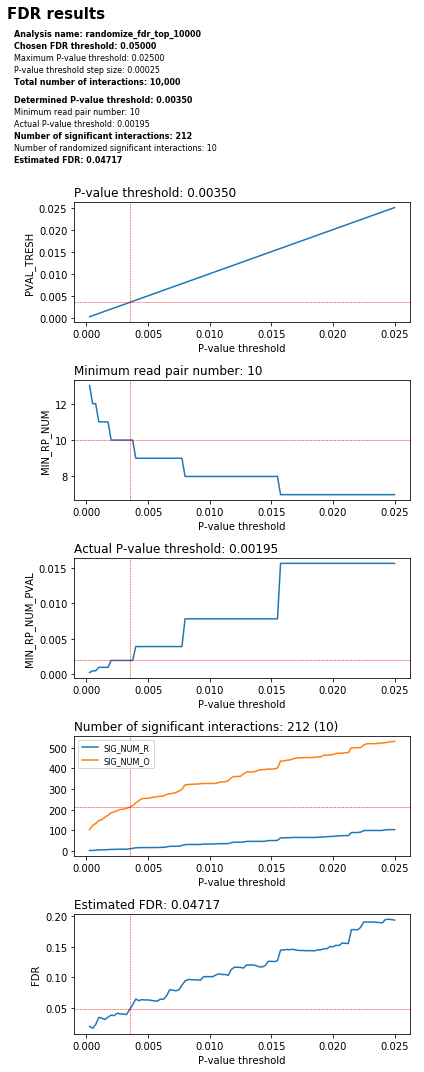

In [9]:
fig = randomize_fdr_top_10000.get_fdr_info_plot(pdf_file_name='randomize_fdr_top_10000.pdf', analysis_name='randomize_fdr_top_10000')

In [6]:
interaction_file_top_100000 = '../tests/data/test_03/diachromatic_interaction_file_fdr_top_100000.tsv.gz'
interaction_set_top_100000 = DiachromaticInteractionSet()
interaction_set_top_100000.parse_file(interaction_file_top_100000, verbose=True)
randomize_fdr_top_100000 = RandomizeInteractionSet(interaction_set=interaction_set_top_100000)
fdr_info_dict_top_100000 = randomize_fdr_top_100000.get_pval_tresh_at_chosen_fdr_tresh(
    chosen_fdr_thresh=chosen_fdr_thresh,
    pval_thresh_max=p_value_max,
    pval_thresh_step_size=p_value_step)

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../tests/data/test_03/diachromatic_interaction_file_fdr_top_100000.tsv.gz
[INFO] ... done.


../diachr/randomize_interaction_set.py:116: UserWarning: FDR did not grow monotonically with P-value threshold!
Take a close look at the results for each of the P-value thresholds.
  warnings.warn("FDR did not grow monotonically with P-value threshold!" + '\n' + \


In [7]:
fdr_info_report = randomize_fdr_top_100000.get_fdr_info_report()
print(fdr_info_report)

[INFO] Report on FDR procedure:
	[INFO] Input parameters:
		[INFO] Chosen FDR threshold: 0.05000
		[INFO] Maximum P-value threshold: 0.02500
		[INFO] P-value threshold step size: 0.00025
		[INFO] Total number of interactions: 100,000
	[INFO] Results:
		[INFO] Determined P-value threshold: 0.00375
		[INFO] Determined -ln(P-value threshold): 5.58600
		[INFO] Minimum read pair number: 10
		[INFO] Smallest possible P-value with 10 read pairs: 0.00195
		[INFO] Number of interactions with 10 or more read pairs: 60,654
		[INFO] Number of significant interactions: 2,477
		[INFO] Number of randomized significant interactions: 106
		[INFO] Estimated FDR: 0.04279
[INFO] End of report.



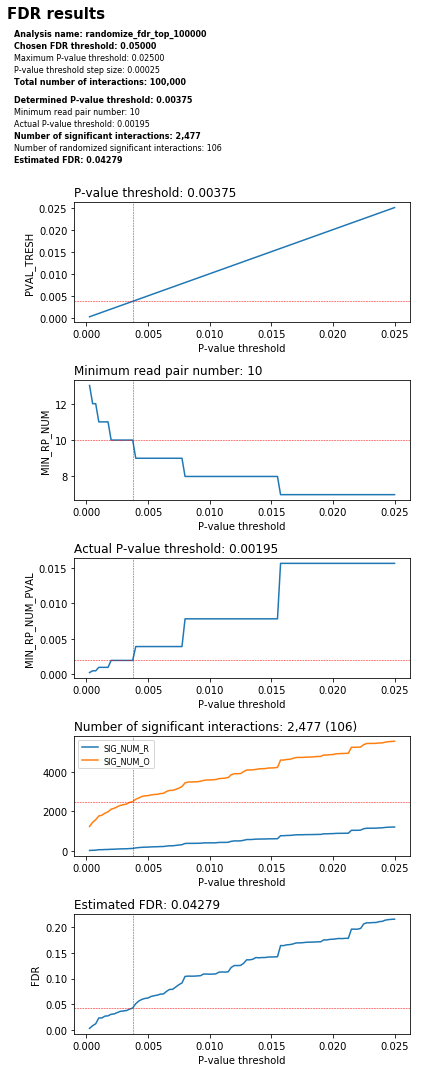

In [12]:
fig = randomize_fdr_top_100000.get_fdr_info_plot(pdf_file_name='randomize_fdr_top_100000.pdf', analysis_name='randomize_fdr_top_100000')

In [13]:
interaction_file_top_1000000 = '../tests/data/test_03/diachromatic_interaction_file_fdr_top_1000000.tsv.gz'
interaction_set_top_1000000 = DiachromaticInteractionSet()
interaction_set_top_1000000.parse_file(interaction_file_top_1000000, verbose=True)
randomize_fdr_top_1000000 = RandomizeInteractionSet(interaction_set=interaction_set_top_1000000)
fdr_info_dict_top_1000000 = randomize_fdr_top_1000000.get_pval_tresh_at_chosen_fdr_tresh(
    chosen_fdr_thresh=chosen_fdr_thresh,
    pval_thresh_max=p_value_max,
    pval_thresh_step_size=p_value_step)

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../tests/data/test_03/diachromatic_interaction_file_fdr_top_1000000.tsv.gz
	[INFO] Parsed 1000000 interaction lines ...
[INFO] ... done.


../diachr/randomize_interaction_set.py:116: UserWarning: FDR did not grow monotonically with P-value threshold!
Take a close look at the results for each of the P-value thresholds.
  warnings.warn("FDR did not grow monotonically with P-value threshold!" + '\n' + \


In [14]:
fdr_info_report = randomize_fdr_top_1000000.get_fdr_info_report()
print(fdr_info_report)

[INFO] Report on FDR procedure:
	[INFO] Input parameters:
		[INFO] Chosen FDR threshold: 0.05000
		[INFO] Maximum P-value threshold: 0.02500
		[INFO] P-value threshold step size: 0.00025
		[INFO] Total number of interactions: 1,000,000
	[INFO] Results:
		[INFO] Determined P-value threshold: 0.00375
		[INFO] Determined -ln(P-value) threshold: 5.58600
		[INFO] Minimum read pair number: 10
		[INFO] Actual P-value threshold: 0.00195
		[INFO] Number of significant interactions: 24,181
		[INFO] Number of randomized significant interactions: 1,189
		[INFO] Estimated FDR: 0.04917
[INFO] End of report.



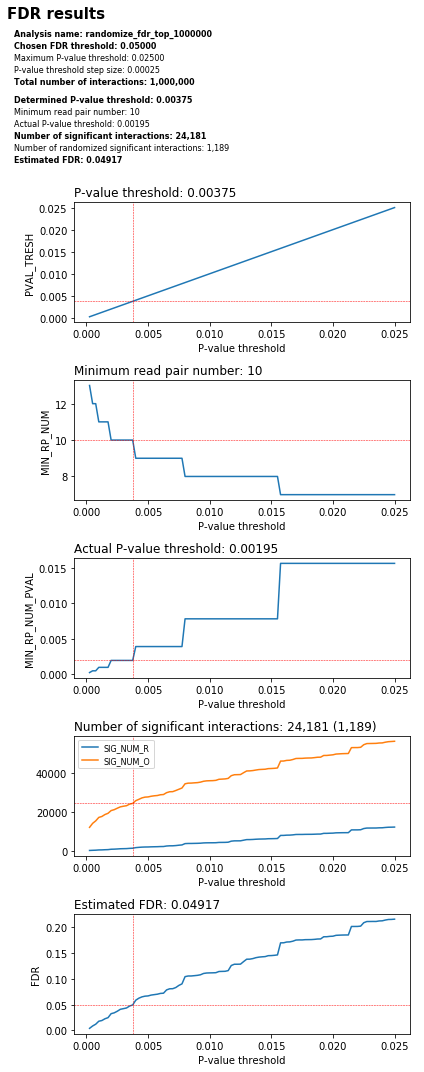

In [16]:
fig = randomize_fdr_top_1000000.get_fdr_info_plot(pdf_file_name='randomize_fdr_top_1000000.pdf', analysis_name='randomize_fdr_top_1000000')

In [17]:
interaction_file_top_2000000 = '../tests/data/test_03/diachromatic_interaction_file_fdr_top_2000000.tsv.gz'
interaction_set_top_2000000 = DiachromaticInteractionSet()
interaction_set_top_2000000.parse_file(interaction_file_top_2000000, verbose=True)
randomize_fdr_top_2000000 = RandomizeInteractionSet(interaction_set=interaction_set_top_2000000)
fdr_info_dict_top_2000000 = randomize_fdr_top_2000000.get_pval_tresh_at_chosen_fdr_tresh(
    chosen_fdr_thresh=chosen_fdr_thresh,
    pval_thresh_max=p_value_max,
    pval_thresh_step_size=p_value_step)

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../tests/data/test_03/diachromatic_interaction_file_fdr_top_2000000.tsv.gz
	[INFO] Parsed 1000000 interaction lines ...
	[INFO] Parsed 2000000 interaction lines ...
[INFO] ... done.


../diachr/randomize_interaction_set.py:116: UserWarning: FDR did not grow monotonically with P-value threshold!
Take a close look at the results for each of the P-value thresholds.
  warnings.warn("FDR did not grow monotonically with P-value threshold!" + '\n' + \


In [18]:
fdr_info_report = randomize_fdr_top_2000000.get_fdr_info_report()
print(fdr_info_report)

[INFO] Report on FDR procedure:
	[INFO] Input parameters:
		[INFO] Chosen FDR threshold: 0.05000
		[INFO] Maximum P-value threshold: 0.02500
		[INFO] P-value threshold step size: 0.00025
		[INFO] Total number of interactions: 2,000,000
	[INFO] Results:
		[INFO] Determined P-value threshold: 0.00375
		[INFO] Determined -ln(P-value) threshold: 5.58600
		[INFO] Minimum read pair number: 10
		[INFO] Actual P-value threshold: 0.00195
		[INFO] Number of significant interactions: 49,074
		[INFO] Number of randomized significant interactions: 2,330
		[INFO] Estimated FDR: 0.04748
[INFO] End of report.



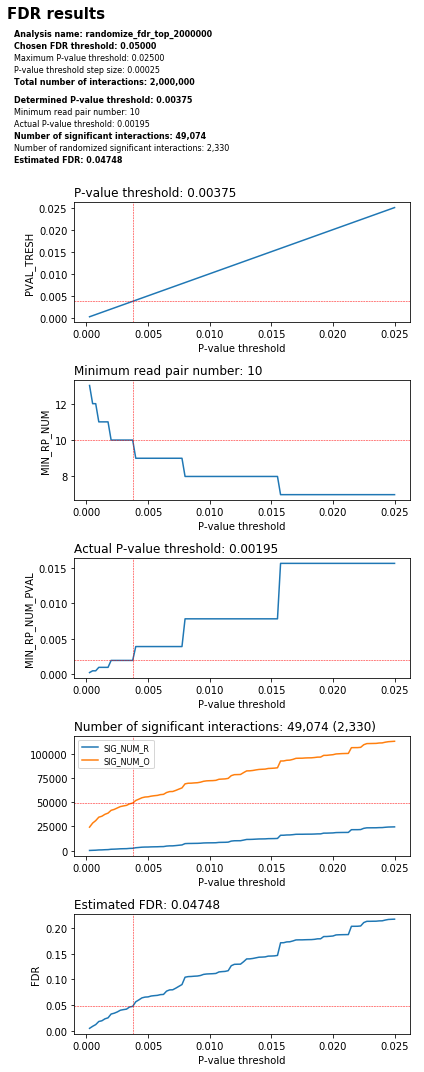

In [19]:
fig = randomize_fdr_top_2000000.get_fdr_info_plot(pdf_file_name='randomize_fdr_top_2000000.pdf', analysis_name='randomize_fdr_top_2000000')

In [20]:
interaction_file_top_4000000 = '../tests/data/test_03/diachromatic_interaction_file_fdr_top_4000000.tsv.gz'
interaction_set_top_4000000 = DiachromaticInteractionSet()
interaction_set_top_4000000.parse_file(interaction_file_top_4000000, verbose=True)
randomize_fdr_top_4000000 = RandomizeInteractionSet(interaction_set=interaction_set_top_4000000)
fdr_info_dict_top_4000000 = randomize_fdr_top_4000000.get_pval_tresh_at_chosen_fdr_tresh(
    chosen_fdr_thresh=chosen_fdr_thresh,
    pval_thresh_max=p_value_max,
    pval_thresh_step_size=p_value_step)

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../tests/data/test_03/diachromatic_interaction_file_fdr_top_4000000.tsv.gz
	[INFO] Parsed 1000000 interaction lines ...
	[INFO] Parsed 2000000 interaction lines ...
	[INFO] Parsed 3000000 interaction lines ...
	[INFO] Parsed 4000000 interaction lines ...
[INFO] ... done.


In [21]:
fdr_info_report = randomize_fdr_top_4000000.get_fdr_info_report()
print(fdr_info_report)

[INFO] Report on FDR procedure:
	[INFO] Input parameters:
		[INFO] Chosen FDR threshold: 0.05000
		[INFO] Maximum P-value threshold: 0.02500
		[INFO] P-value threshold step size: 0.00025
		[INFO] Total number of interactions: 4,000,000
	[INFO] Results:
		[INFO] Determined P-value threshold: 0.00375
		[INFO] Determined -ln(P-value) threshold: 5.58600
		[INFO] Minimum read pair number: 10
		[INFO] Actual P-value threshold: 0.00195
		[INFO] Number of significant interactions: 98,139
		[INFO] Number of randomized significant interactions: 4,629
		[INFO] Estimated FDR: 0.04717
[INFO] End of report.



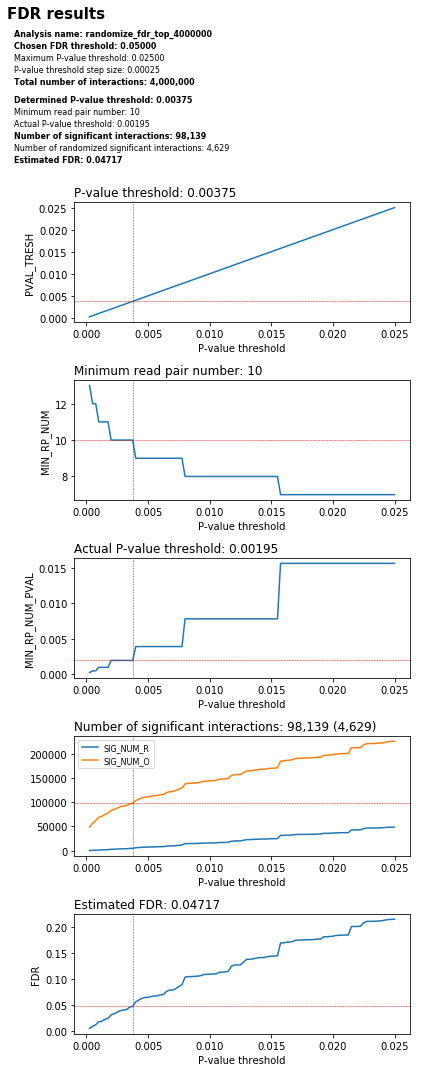

In [23]:
fig = randomize_fdr_top_4000000.get_fdr_info_plot(pdf_file_name='randomize_fdr_top_4000000.pdf', analysis_name='randomize_fdr_top_4000000')

In [8]:
interaction_file_top_8000000 = '../tests/data/test_03/diachromatic_interaction_file_fdr_top_8000000.tsv.gz'
interaction_set_top_8000000 = DiachromaticInteractionSet()
interaction_set_top_8000000.parse_file(interaction_file_top_8000000, verbose=True)
randomize_fdr_top_8000000 = RandomizeInteractionSet(interaction_set=interaction_set_top_8000000)
fdr_info_dict_top_8000000 = randomize_fdr_top_8000000.get_pval_tresh_at_chosen_fdr_tresh(
    chosen_fdr_thresh=chosen_fdr_thresh,
    pval_thresh_max=p_value_max,
    pval_thresh_step_size=p_value_step)

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../tests/data/test_03/diachromatic_interaction_file_fdr_top_8000000.tsv.gz
	[INFO] Parsed 1000000 interaction lines ...
	[INFO] Parsed 2000000 interaction lines ...
	[INFO] Parsed 3000000 interaction lines ...
	[INFO] Parsed 4000000 interaction lines ...
	[INFO] Parsed 5000000 interaction lines ...
	[INFO] Parsed 6000000 interaction lines ...
	[INFO] Parsed 7000000 interaction lines ...
	[INFO] Parsed 8000000 interaction lines ...
[INFO] ... done.


In [9]:
fdr_info_report = randomize_fdr_top_8000000.get_fdr_info_report()
print(fdr_info_report)

[INFO] Report on FDR procedure:
	[INFO] Input parameters:
		[INFO] Chosen FDR threshold: 0.05000
		[INFO] Maximum P-value threshold: 0.02500
		[INFO] P-value threshold step size: 0.00025
		[INFO] Total number of interactions: 8,000,000
	[INFO] Results:
		[INFO] Determined P-value threshold: 0.00375
		[INFO] Determined -ln(P-value threshold): 5.58600
		[INFO] Minimum read pair number: 10
		[INFO] Smallest possible P-value with 10 read pairs: 0.00195
		[INFO] Number of interactions with 10 or more read pairs: 4,886,564
		[INFO] Number of significant interactions: 196,005
		[INFO] Number of randomized significant interactions: 9,400
		[INFO] Estimated FDR: 0.04796
[INFO] End of report.



In [9]:
randomize_fdr_top_8000000.get_num_of_inter_with_as_many_or_more_read_pairs(10)

4886564

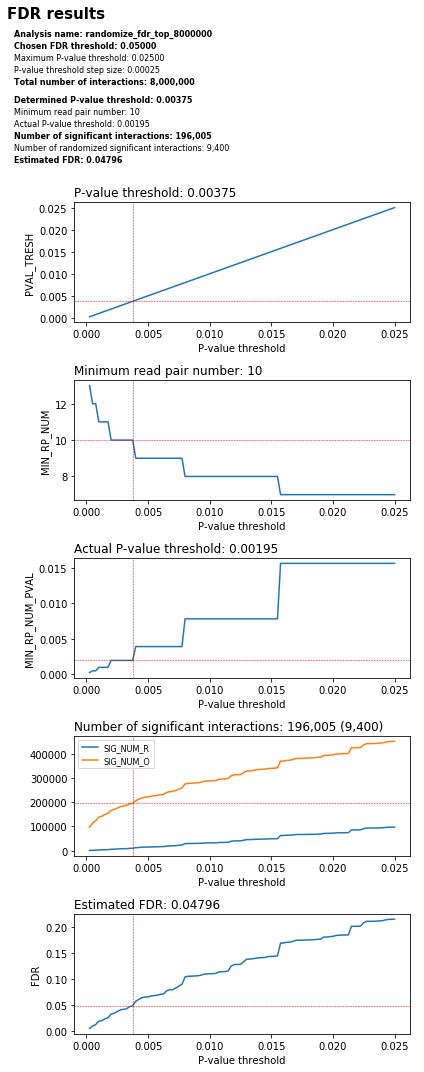

In [26]:
fig = randomize_fdr_top_8000000.get_fdr_info_plot(pdf_file_name='randomize_fdr_top_8000000.pdf', analysis_name='randomize_fdr_top_8000000')

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

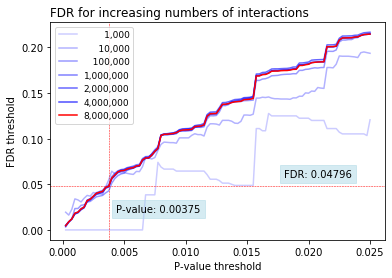

In [102]:
pval_threshs = fdr_info_dict_top_8000000['RESULTS_TABLE']['PVAL_THRESH']

plt.plot(pval_threshs, fdr_info_dict_top_1000['RESULTS_TABLE']['FDR'], color=(0,0,1,0.2), label='       ' + "{:,}".format(1000))
plt.plot(pval_threshs, fdr_info_dict_top_10000['RESULTS_TABLE']['FDR'], color=(0,0,1,0.3), label='     ' + "{:,}".format(10000))
plt.plot(pval_threshs, fdr_info_dict_top_100000['RESULTS_TABLE']['FDR'], color=(0,0,1,0.4), label='   ' + "{:,}".format(100000))
plt.plot(pval_threshs, fdr_info_dict_top_1000000['RESULTS_TABLE']['FDR'], color=(0,0,1,0.5), label="{:,}".format(1000000))
plt.plot(pval_threshs, fdr_info_dict_top_2000000['RESULTS_TABLE']['FDR'], color=(0,0,1,0.6), label="{:,}".format(2000000))
plt.plot(pval_threshs, fdr_info_dict_top_4000000['RESULTS_TABLE']['FDR'], color=(0,0,1,0.7), label="{:,}".format(4000000))
plt.plot(pval_threshs, fdr_info_dict_top_8000000['RESULTS_TABLE']['FDR'], color=(1,0,0,1), label="{:,}".format(8000000))

result_index = fdr_info_dict_top_8000000['RESULT_INDEX'][0]
fdr_result = fdr_info_dict_top_8000000['RESULTS_TABLE']['FDR'][result_index]
pval_thresh_result = fdr_info_dict_top_8000000['RESULTS_TABLE']['PVAL_THRESH'][result_index]
plt.axhline(fdr_result, linestyle='--', color='red', linewidth=0.5)
plt.axvline(pval_thresh_result, linestyle='--', color='red', linewidth=0.5)

plt.text(0.018, fdr_result + 0.01,'FDR: ' + "{:.5f}".format(fdr_result), bbox={'color': 'lightblue', 'alpha': 0.5, 'pad': 4})
plt.text(pval_thresh_result + 0.000625, 0.02,'P-value: ' + "{:.5f}".format(pval_thresh_result), bbox={'color': 'lightblue', 'alpha': 0.5, 'pad': 4})
plt.xlabel('P-value threshold')
plt.ylabel('FDR threshold')

plt.title('FDR for increasing numbers of interactions', loc='left')
plt.legend(fontsize=9)

plt.savefig('fdr_for_increasing_numbers_of_interactions.pdf')
plt.show()


In [9]:
fdr_list = fdr_info_dict_top_8000000['RESULTS_TABLE']['FDR']
previous_fdr = fdr_list[0]
for current_fdr in fdr_list:
    if current_fdr < previous_fdr:
        print(current_fdr)
        
#all(x>=y for x, y in zip(fdr_list,fdr_list[1:]))

for x, y in zip(fdr_list,fdr_list[1:]):
    if x>y:
        print(str(x) + '\t' + str(y))